C:\Users\tiruu\AppData\Local\Temp\ipykernel_10536\4224978479.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=D

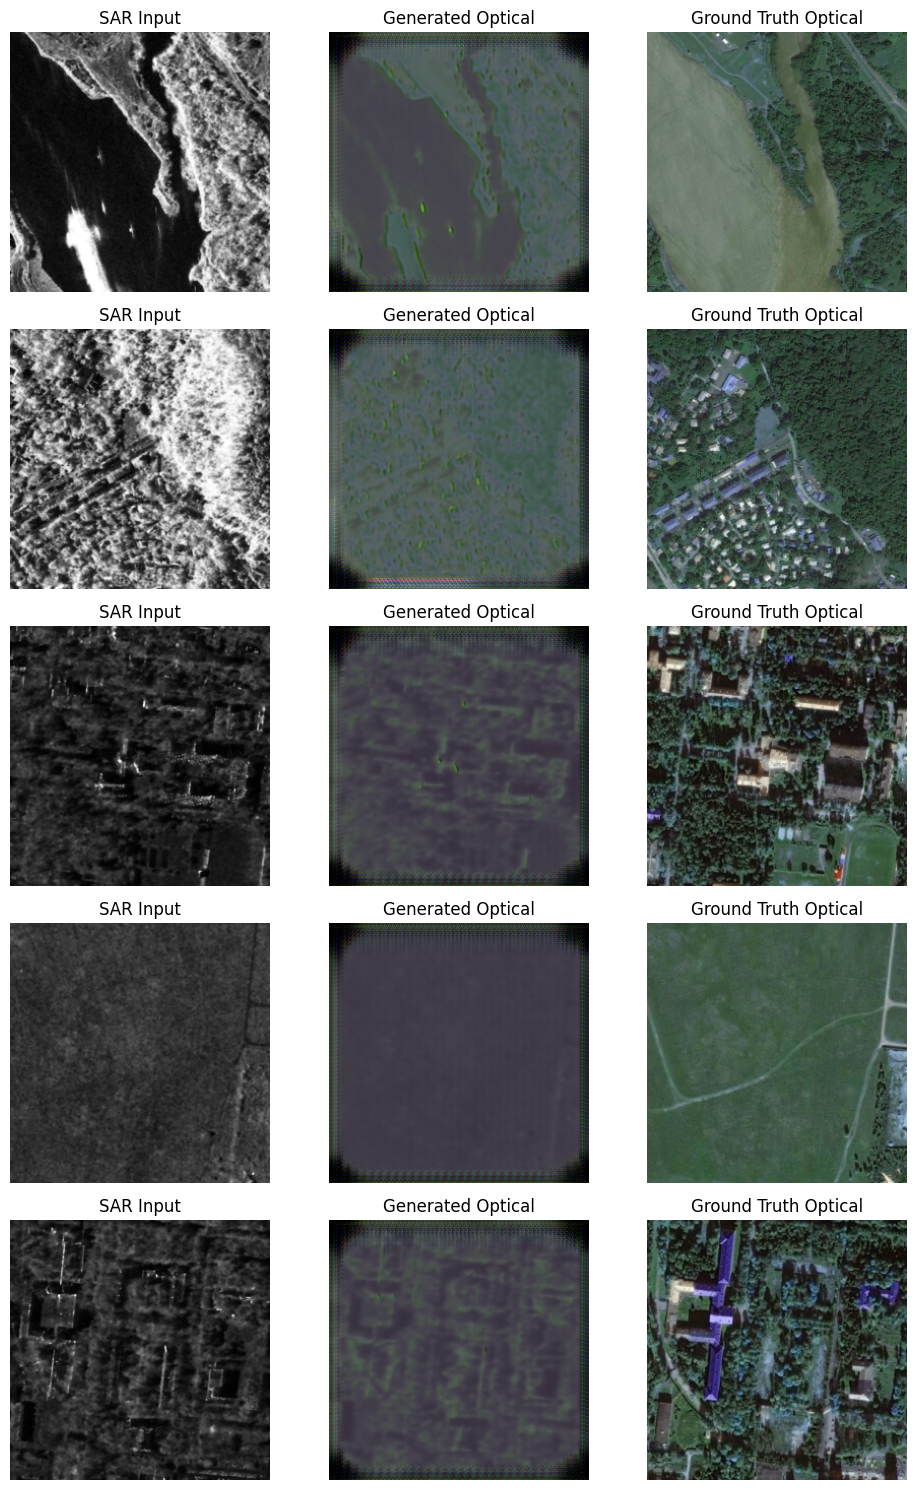

In [1]:
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import Normalize
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from models.UNet import UNet
from utils.helpers import test_loader

# Путь к сохранённой модели
MODEL_PATH = "./saved_models/best_generator_patchgan.pth"
DEVICE = torch.device("cpu")

# Загрузка модели
model = UNet(in_channels=1, output_channels=3).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# Обратная нормализация (для преобразования из [-1, 1] в [0, 1])
def denormalize_image(tensor):
    denorm = Normalize(mean=(-1,), std=(2,))  # Обратная нормализация
    return torch.clamp(denorm(tensor), 0, 1)  # Ограничиваем диапазон [0, 1]

# Функция для визуализации результатов
def visualize_results(loader, model, device, num_images=5):
    model.eval()
    sar_images, generated_images, ground_truths = [], [], []

    # Прогон через модель
    with torch.no_grad():
        for i, (sar, optical) in enumerate(loader):
            if i >= num_images:
                break
            
            sar, optical = sar.to(device), optical.to(device)
            output = model(sar)  # Генерируем оптическое изображение
            
            # Добавляем данные в списки
            sar_images.append(sar.cpu())
            generated_images.append(output.cpu())
            ground_truths.append(optical.cpu())

    # Отображение результатов
    fig, axs = plt.subplots(num_images, 3, figsize=(10, num_images * 3))
    for i in range(num_images):
        # SAR изображение (преобразуем из [1, H, W] в [H, W])
        sar_image = sar_images[i][0].squeeze(0).numpy()  # Извлекаем первое изображение из батча

        axs[i, 0].imshow(sar_image, cmap="gray")
        axs[i, 0].set_title("SAR Input")
        axs[i, 0].axis("off")

        # Сгенерированное оптическое изображение
        generated_image = denormalize_image(generated_images[i][0]).permute(1, 2, 0).numpy()  # Извлекаем первое изображение из батча
        axs[i, 1].imshow(generated_image)
        axs[i, 1].set_title("Generated Optical")
        axs[i, 1].axis("off")

        # Целевое оптическое изображение
        ground_truth = denormalize_image(ground_truths[i][0]).permute(1, 2, 0).numpy()  # Извлекаем первое изображение из батча
        axs[i, 2].imshow(ground_truth)
        axs[i, 2].set_title("Ground Truth Optical")
        axs[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

# Визуализация первых 5 изображений из тестового набора
if __name__ == "__main__":
    visualize_results(test_loader, model, DEVICE, num_images=5)


In [2]:
import numpy as np
import matplotlib.pyplot as plt

prev_train_loss = []
prev_val_loss = []

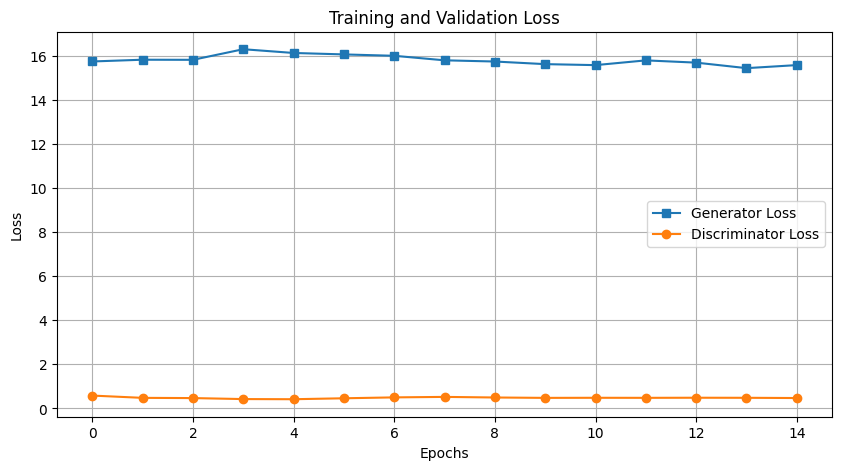

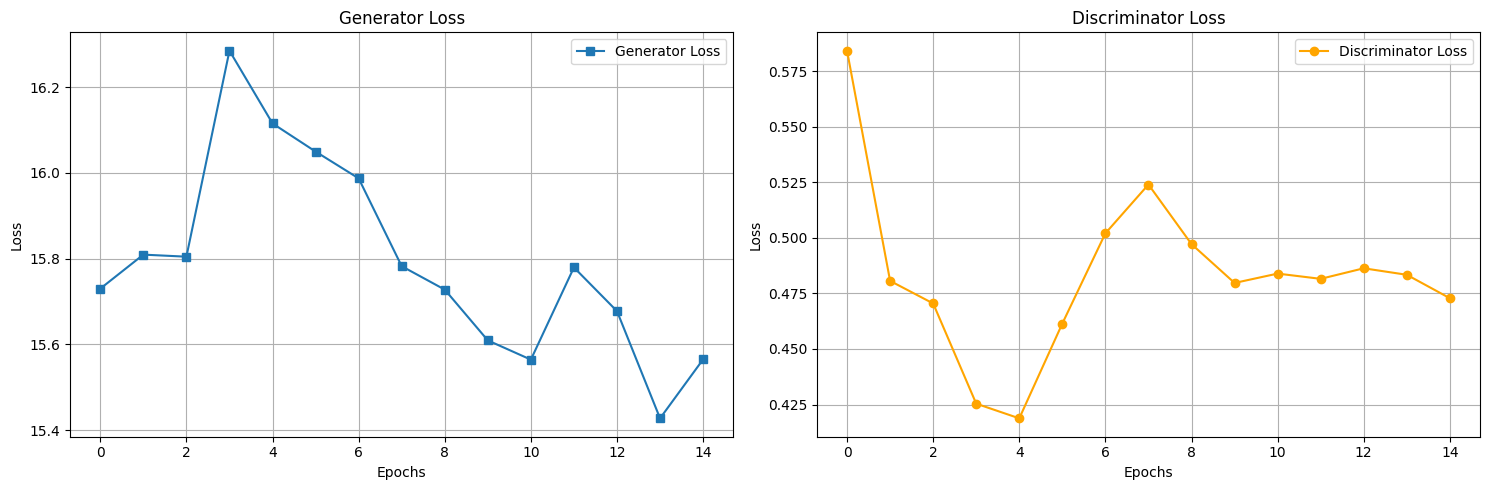

In [4]:
data  = np.load('./logs/losses.npz')
train_loss = np.concatenate((prev_train_loss, data['train_losses']))
val_loss = np.concatenate((prev_val_loss, data['val_losses']))

# Построение графиков
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Generator Loss', marker='s')
plt.plot(val_loss, label='Discriminator Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()



# Построение графиков с использованием subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# График для Train Loss
axes[0].plot(train_loss, label='Generator Loss', marker='s')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Generator Loss')
axes[0].legend()
axes[0].grid(True)

# График для Validation Loss
axes[1].plot(val_loss, label='Discriminator Loss', marker='o', color='orange')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Discriminator Loss')
axes[1].legend()
axes[1].grid(True)

# Отображение графиков
plt.tight_layout()
plt.show()
